In [1]:
import sys, os
import folium
sys.path.append('..')
import flickrapi
import nationalparks.clusters as clusters
import nationalparks.secrets as secrets
import nationalparks.parks as parks
import scrapper.fetch_images as fetch_images
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
import geopandas as gpd
from update_database import update_clusters

In [3]:
parkunit = 'acad'
my_park = parks.Park(parkunit)

In [4]:
df_photos = my_park.get_photos()

In [51]:
tag_counters = {}

for i, row in df_photos[df_photos['tags'].notnull()].iterrows():
    
    ## create tag list
    tag_list = row['tags'].split(' ')
    
    if tag_list and not tag_list is None:
        
        if not row['labels'] in tag_counters.keys():
            tag_counters[row['labels']] = {}
        
        for tag in tag_list:
            if tag in tag_counters[row['labels']].keys():
                tag_counters[row['labels']][tag] +=1
            else:
                tag_counters[row['labels']][tag] = 1

In [61]:
sorted(tag_counters[29].items(), key=lambda x: x[1],reverse=True)[0:5]

[('maine', 974),
 ('acadianationalpark', 478),
 ('lighthouse', 460),
 ('acadia', 381),
 ('bassharbor', 285)]

In [73]:
def similarity_matrix(tag_counters):
    jacindex = np.zeros(shape=(len(tag_counters), len(tag_counters)))

    for i, a in enumerate(tag_counters.keys()):
        for j, b in enumerate(tag_counters.keys()):
                if not a == b:
                    ji = round(jaccard_index(tag_counters[a],tag_counters[b]), 2)
                    jacindex[i][j] = ji
                else:
                    jacindex[i][j] = np.nan
    return jacindex

In [77]:
df_photos['labels'].value_counts()

258    5920
194    4119
114    1707
29     1609
300     823
216     616
270     528
115     517
41      491
66      473
89      450
180     447
286     422
57      309
178     299
125     277
248     275
267     273
285     227
33      214
Name: labels, dtype: int64

89


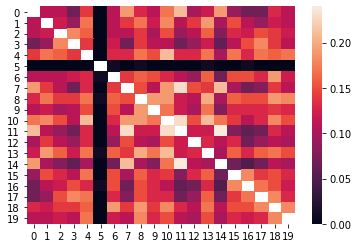

In [72]:
sns.heatmap(similarity_matrix(tag_counters))

In [45]:
def jaccard_index(tags_cluster_1, tags_cluster_2):
        '''
        Returns the Jaccard Similarity Index between two cluster's tags
        '''
        
        if len(set(tags_cluster_1)) == 0 and len(set(tags_cluster_2)) == 0:
            return 0
        else:
            shared = len(set(tags_cluster_1).intersection(tags_cluster_2))
            return shared / float(len(set(tags_cluster_1)) + len(set(tags_cluster_2)) - shared)

In [46]:
jaccard_index(tag_counters[300], tag_counters[33])

0.11462450592885376

In [47]:
max_jaccard = 0
best_pair = ()
for i in tag_counters.keys():
    for j in tag_counters.keys():
        if i!=j:
            if jaccard_index(tag_counters[i], tag_counters[j]) > max_jaccard:
                max_jaccard = jaccard_index(tag_counters[i], tag_counters[j])
                best_pair = (i, j)

In [48]:
best_pair

(194, 258)

In [40]:
max_jaccard

0.24259259259259258

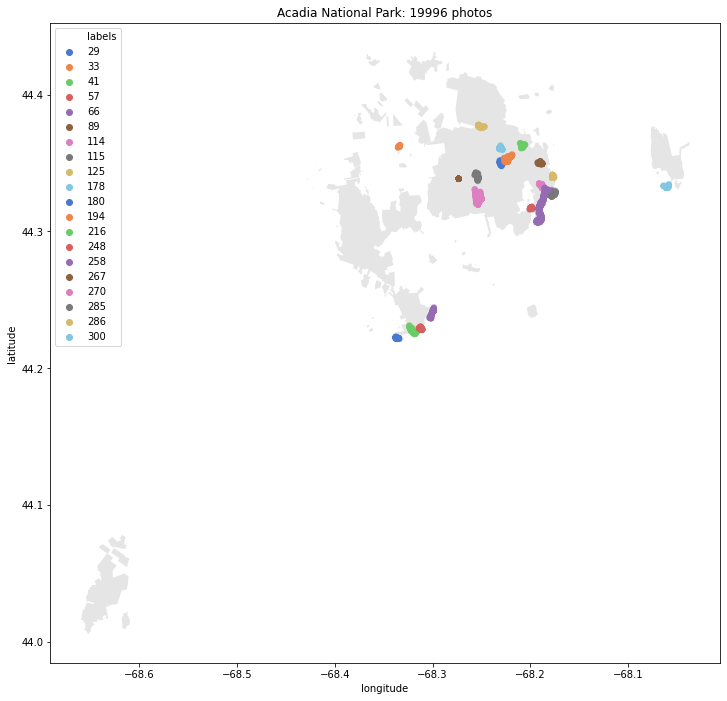

In [49]:
my_park.plot_all_photos()